<a href="https://colab.research.google.com/github/OwenHuels/data-science/blob/main/OwenHuelU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

#**Unit 5 Project: Dependency of Penguin Bill Length on Flipper Length**

##**Context**

Penguins are cool. Literally. Penguins use their flipper to swim around and their bills to eat. I'm curious to see if there's a linear ( orgeneralized linear) dependency of the bill length of a given penguin on its flipper length, because I'm not sure if the functional aspects of these body parts are actually related at all.

I'll be using the data set from the github. This data set contains other information about the penguins such as their gender and bill depth, but we only care about bill length and flipper length.

##**Data**

Before we begin to create and test models, here is the raw data and visualization.

In [2]:
#raw data csv from Mr. Arredondo's github
url_peng = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv'

peng = pd.read_csv(url_peng)

#view data
peng

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


In [3]:
#remove penguins without required information from the data set
peng = peng.dropna(subset=['flipper_length', 'bill_length'])
#reset indexes after removal to make the data look nicer
peng.reset_index(drop=True, inplace=True)
peng

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
3,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
4,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
337,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
338,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
339,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
340,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


As you can see, now we have a data set without those penguins who didn't have any data on their flipper and bill lengths.

<Axes: xlabel='flipper_length', ylabel='bill_length'>

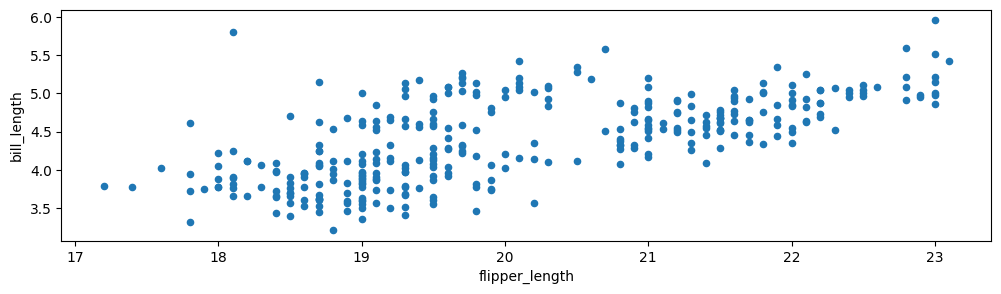

In [31]:
#scatter plot of flipper length v. bill length of penguins
peng.plot(x="flipper_length", y="bill_length", figsize=(12, 3), kind="scatter")

There's clearly some correlation here, although I'm not sure how strong it is and whether it's linear or not. Let's run some models to find out.

##**Models**

I don't have any outside knowledge to inform my priors, so I'll just be using the most basic, uninformative priors I can. I'm going to start off by just running a straight up linear model and seeing how it goes.

In [5]:
#lp stands for linear penguins
with pm.Model() as model_lp:

    #priors for our mean line
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * peng.flipper_length)

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=peng.bill_length)

    idata_lp = pm.sample()

Output()

Output()

In [6]:
#creates our posterior predictive distribution
pm.sample_posterior_predictive(
    idata_lp, model = model_lp, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'bill length')

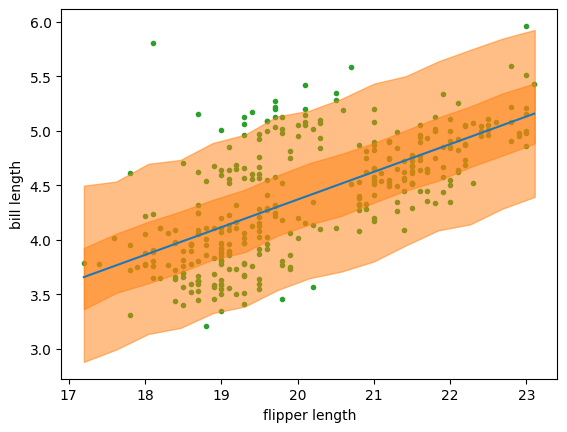

In [7]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_lp.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
lengths = np.random.normal(peng.flipper_length.values, 0.01)
idx = np.argsort(lengths)
x = np.linspace(lengths.min(), lengths.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_lp.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(lengths[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(peng.flipper_length, peng.bill_length, "C2.", zorder=-3)
ax.plot(peng.flipper_length[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("flipper length")
ax.set_ylabel("bill length")

There seems to be a decent correlation here, but a lot of points fall far away from the line. Let's check the posterior predictive to get a more clear view of how good the model is.

<Axes: xlabel='y_pred'>

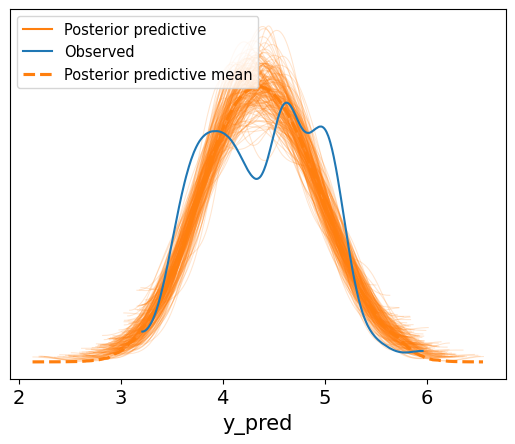

In [8]:
#posterior predictive check
az.plot_ppc(idata_lp, num_pp_samples=200, colors=["C1", "C0", "C1"])

The posterior predictive doesn't look too good. The general shape is ok, but the observed data has those three peaks in the middle that our posterior predictive can't recreate.

I'm going to adjust the model to be variable variance, because it looks to me like there's more variance at lower flipper lengths than at higher ones. I'll also use uninformative priors for the standard deviation deterministic.

In [9]:
#lvvp stands for variable variance penguins
with pm.Model() as model_lvvp:

    #priors for our mean line
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #priors for the line for our standard deviation
    γ = pm.HalfNormal("γ", sigma=10)
    δ = pm.HalfNormal("δ", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * peng.flipper_length)

    #standard deviation line
    σ = pm.Deterministic("σ", γ + δ * peng.flipper_length)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=peng.bill_length)

    idata_lvvp = pm.sample()

Output()

Output()

In [10]:
#creates our posterior predictive distribution
pm.sample_posterior_predictive(
    idata_lvvp, model = model_lvvp, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'bill length')

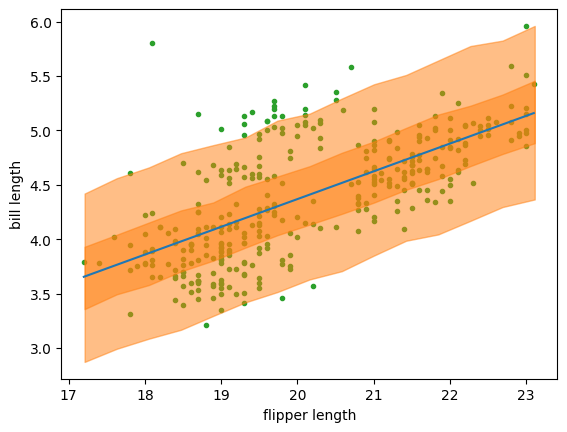

In [11]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_lvvp.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
lengths = np.random.normal(peng.flipper_length.values, 0.01)
idx = np.argsort(lengths)
x = np.linspace(lengths.min(), lengths.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_lvvp.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(lengths[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(peng.flipper_length, peng.bill_length, "C2.", zorder=-3)
ax.plot(peng.flipper_length[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("flipper length")
ax.set_ylabel("bill length")

<Axes: xlabel='y_pred'>

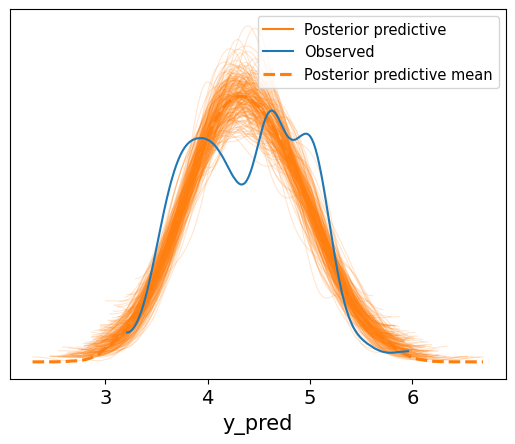

In [12]:
#posterior predictive check
az.plot_ppc(idata_lvvp, num_pp_samples=200, colors=["C1", "C0", "C1"])

This looks about the same as the previous results, with the three peaks still being missing, so I don't think variable variance is the solution.

Let's try a logarithmic GLM and see if it does better.

In [13]:
#lgp stands for logarithm penguins
with pm.Model() as model_lgp:

    #priors for our mean line
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * pm.math.log(peng.flipper_length))

    #standard deviation line
    σ = pm.HalfNormal("σ", sigma=10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=peng.bill_length)

    idata_lgp = pm.sample()

Output()

Output()

In [14]:
#creates our posterior predictive distribution
pm.sample_posterior_predictive(
    idata_lgp, model = model_lgp, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'bill length')

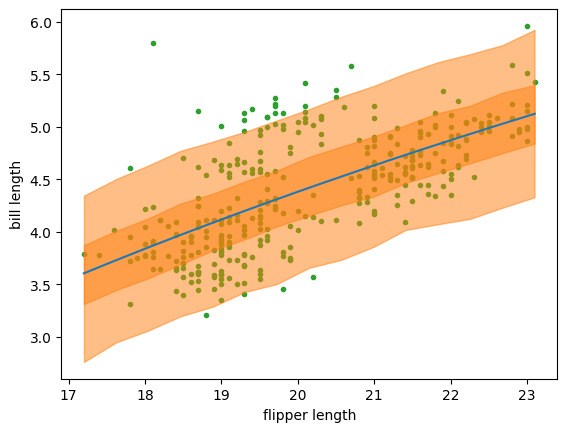

In [15]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_lgp.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
lengths = np.random.normal(peng.flipper_length.values, 0.01)
idx = np.argsort(lengths)
x = np.linspace(lengths.min(), lengths.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_lgp.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(lengths[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(peng.flipper_length, peng.bill_length, "C2.", zorder=-3)
ax.plot(peng.flipper_length[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("flipper length")
ax.set_ylabel("bill length")

<Axes: xlabel='y_pred'>

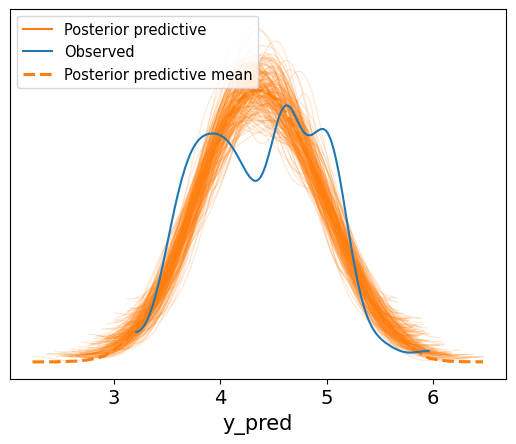

In [16]:
#posterior predictive check
az.plot_ppc(idata_lgp, num_pp_samples=200, colors=["C1", "C0", "C1"])

Wow, that still doesn't look very good.

I notice now that the penguins data set has three different types of penguins: Adelie, Gentoo, and Chinstrap. There's probably a different slope and intercept for each different type of penguin, so if I seperate them into their own models, that might solve my problem. That would also explain why I keep seeing these three peaks, because they each correspond to the three different penguin species.

First we need to make some changes to the data set to allow the model to create three seperate models, one for each species.

In [17]:
#turn the species column into categories for each team
peng['species'] = peng['species'].astype('category')
peng

<ipython-input-17-c9d2d1e03da9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peng['species'] = peng['species'].astype('category')


,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
3,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
4,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
337,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
338,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
339,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
340,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


In [18]:
#this is an array of the species,
#except they are given an int (number) label instead of a string
species_idx = peng.species.cat.codes.values

#an array of the three strings that represent species
species_codes = peng.species.cat.categories

#puts coords in a dict, so pymc can read them
species_coords = {"species": species_codes}

Now we can make a new scatter plot, seperated by species.

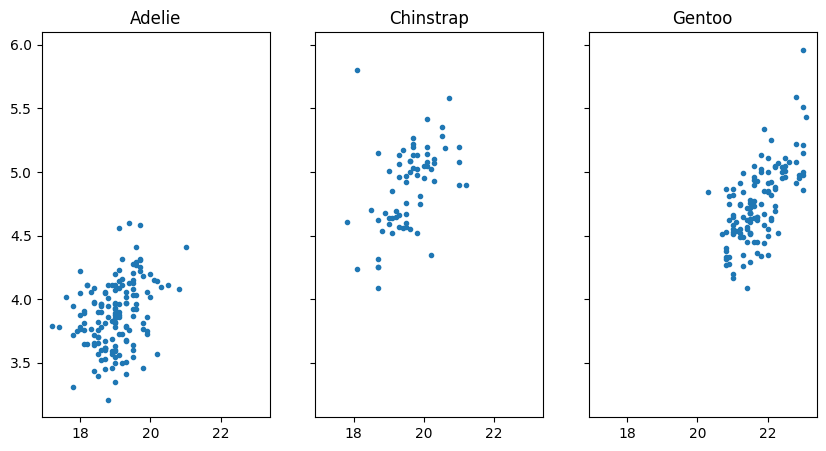

In [19]:
#set up the 3 plots
_, ax = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#make a scatter plot for each species
for i, p in enumerate(species_codes):
    ax[i].scatter(
        x = peng.query('species == @p')['flipper_length'],
        y =  peng.query('species == @p')['bill_length'],
        marker=".")
    ax[i].set_title(f"{p}")


It's clear, even more than before, that each species does have a linear relationship between flipper length and bill length; let's run a model to see if the exact relationship is different between species.



In [20]:
#nh for non hierarchical
with pm.Model(coords=species_coords) as nh_model:
    #priors
    α = pm.Normal("α", mu=0, sigma=10, dims="species")
    β = pm.Normal("β", mu=0, sigma=10, dims="species")
    σ = pm.HalfNormal("σ", sigma=10)

    #likelihood
    #the linear part of the model is put directly into mu
    y = pm.Normal("y_pred",
                  mu=α[species_idx] + β[species_idx] * peng['flipper_length'],
                  sigma=σ,
                  observed=peng['bill_length'])
    idata_nh = pm.sample()

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


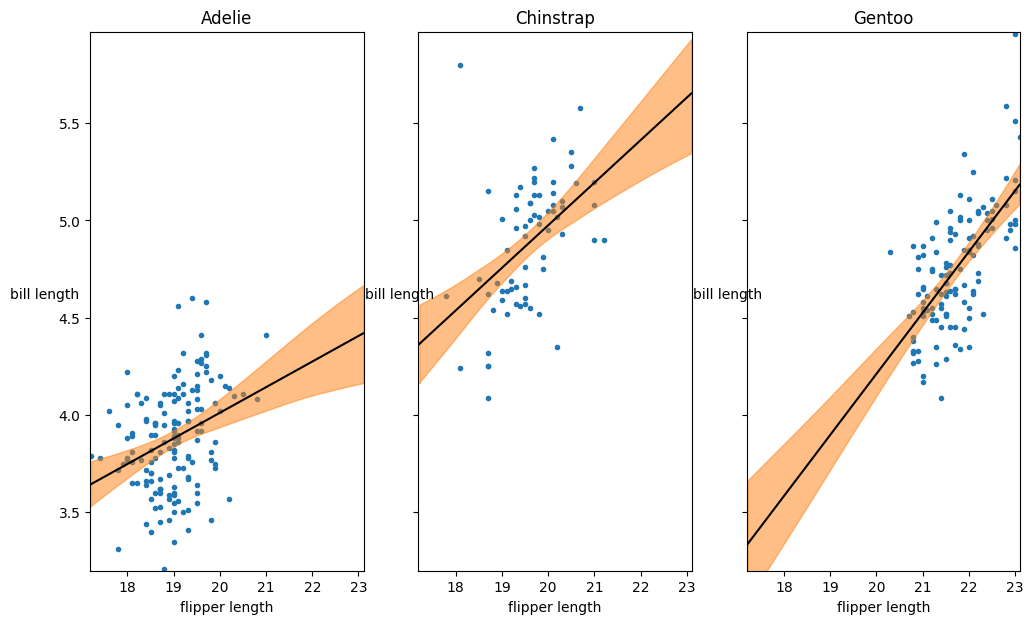

In [21]:
#set out our 3 plots
_, ax = plt.subplots(1, 3, figsize=(12, 7), sharex=True, sharey=True)
ax = np.ravel(ax)

#set up x values. Used to graph line of best fit
x_range = np.linspace(peng['flipper_length'].min(), peng['flipper_length'].max(), 10)

#grab posterior info
posterior = az.extract(idata_nh)

#for each species
for i, p in enumerate(species_codes):
    #plot the raw data
    ax[i].scatter(
        x = peng.query('species == @p')['flipper_length'],
        y = peng.query('species == @p')['bill_length'],
        marker=".")

    #gives our graphs titles and labels
    ax[i].set_title(f"{p}")
    ax[i].set_xlabel("flipper length")
    ax[i].set_ylabel("bill length", labelpad=10, rotation=0)

    #grab the slope and y-int
    alphas = posterior["α"].sel(species=p)
    betas = posterior["β"].sel(species=p)
    alpha_m = alphas.mean("sample").item()
    beta_m = betas.mean("sample").item()

    #plot the mean line, or line of best fit
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c="k")

    #plot a 94% HDI of the line of best fit.
    az.plot_hdi(x_range, alphas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])

    #set the limits of our graphs' window
    plt.xlim(peng['flipper_length'].min() - 0.01, peng['flipper_length'].max() + 0.01)
    plt.ylim(peng['bill_length'].min() - 0.01, peng['bill_length'].max() + 0.01)

All three species have a linear relationship, which is good. However, we can see that the model is less confident in this relationship between different species. Gentoo penguins have a very strong linear relationship between flipper length and bill length, while the relationship for Adelie penguins is not as strong, although it is clearly present. We can check the posterior predictive to get more information about how our model did.

In [22]:
pm.sample_posterior_predictive(idata_nh, model=nh_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

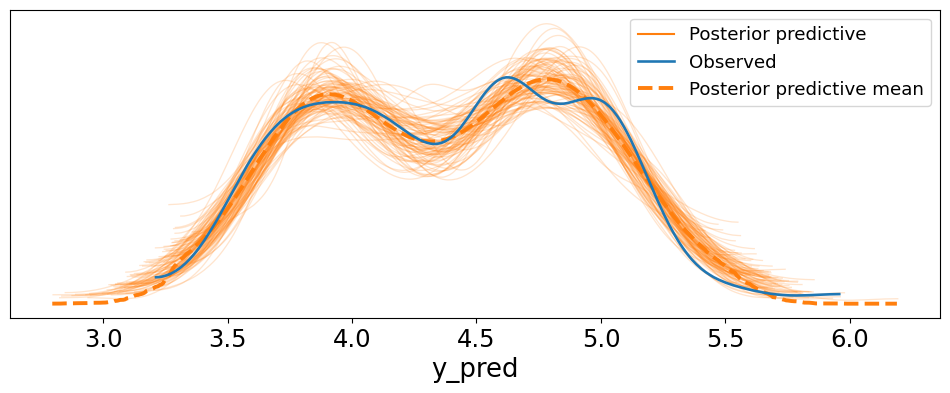

In [23]:
#Plots the posterior predictive density overlaid with a smoothed version of the data

ax = az.plot_ppc(idata_nh, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

This ppc looks really good! It follows the humped shape much better now, and the tails are matched almost perfectly to the observed data. The only thing that's missing is distinguishing between the second and third peaks, but they're so close together than the model can predict relatively well anyway.

This model works very well, but I'm going to see if I can make it even better by running a variable variance nonhierarchical model to see if that can help make the three peaks be more distinguishable from each other.

In [26]:
#nhvv for non hierarchical variable variance
with pm.Model(coords=species_coords) as nhvv_model:
    #priors
    α = pm.Normal("α", mu=0, sigma=10, dims="species")
    β = pm.Normal("β", mu=0, sigma=10, dims="species")

    γ = pm.HalfNormal("γ", sigma=10, dims="species")
    δ = pm.HalfNormal("δ", sigma=10, dims="species")

    #likelihood
    #the linear part of the model is put directly into mu
    y = pm.Normal("y_pred",
                  mu=α[species_idx] + β[species_idx] * peng['flipper_length'],
                  sigma=γ[species_idx] + δ[species_idx] * peng['flipper_length'],
                  observed=peng['bill_length'])

    idata_nhvv = pm.sample()

Output()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


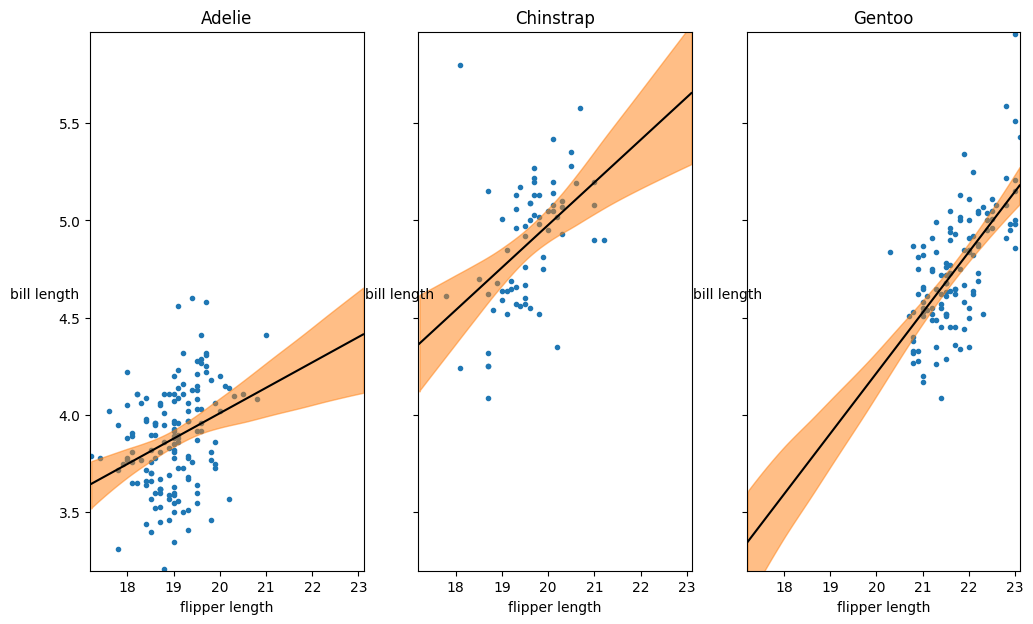

In [27]:
#set out our 3 plots
_, ax = plt.subplots(1, 3, figsize=(12, 7), sharex=True, sharey=True)
ax = np.ravel(ax)

#set up x values. Used to graph line of best fit
x_range = np.linspace(peng['flipper_length'].min(), peng['flipper_length'].max(), 10)

#grab posterior info
posterior = az.extract(idata_nhvv)

#for each species
for i, p in enumerate(species_codes):
    #plot the raw data
    ax[i].scatter(
        x = peng.query('species == @p')['flipper_length'],
        y = peng.query('species == @p')['bill_length'],
        marker=".")

    #gives our graphs titles and labels
    ax[i].set_title(f"{p}")
    ax[i].set_xlabel("flipper length")
    ax[i].set_ylabel("bill length", labelpad=10, rotation=0)

    #grab the slope and y-int
    alphas = posterior["α"].sel(species=p)
    betas = posterior["β"].sel(species=p)
    alpha_m = alphas.mean("sample").item()
    beta_m = betas.mean("sample").item()

    #plot the mean line, or line of best fit
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c="k")

    #plot a 94% HDI of the line of best fit.
    az.plot_hdi(x_range, alphas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])

    #set the limits of our graphs' window
    plt.xlim(peng['flipper_length'].min() - 0.01, peng['flipper_length'].max() + 0.01)
    plt.ylim(peng['bill_length'].min() - 0.01, peng['bill_length'].max() + 0.01)

In [28]:
pm.sample_posterior_predictive(idata_nhvv, model=nhvv_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

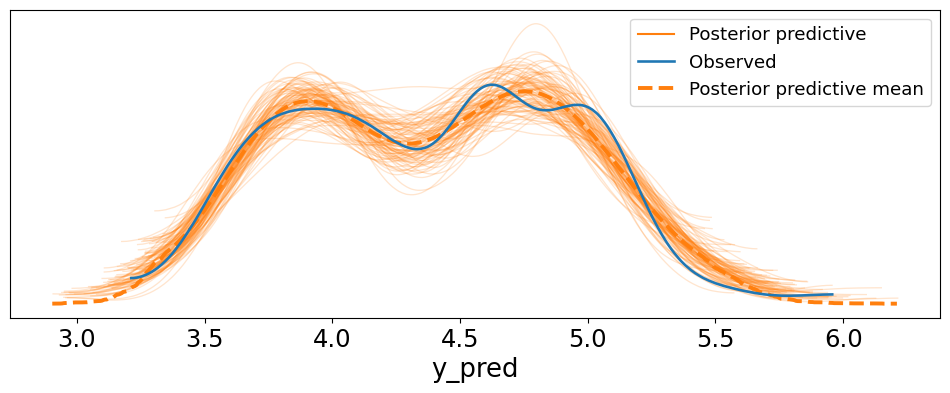

In [29]:
#Plots the posterior predictive density overlaid with a smoothed version of the data

ax = az.plot_ppc(idata_nhvv, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

I can't see any notable differences in this posterior predictive to the previous one. I'm pretty happy with this model though, so I'll take it. Let's see what the actual linear equation (by displaying the slope and intercept) that the model came up with for each species were.

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

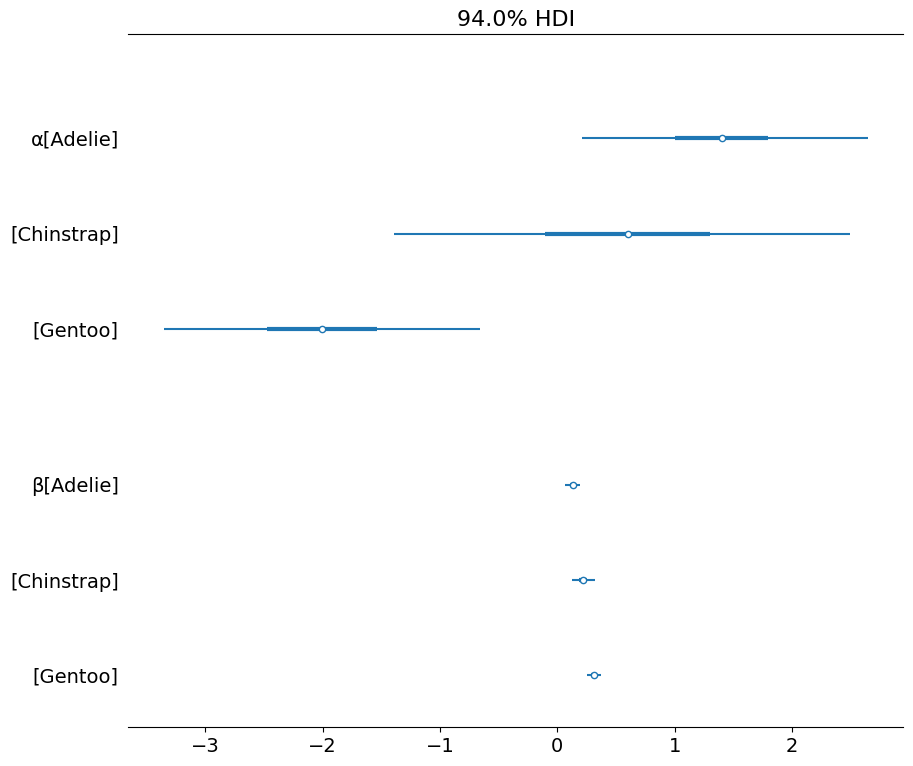

In [30]:
#plots the y-int and slope for each species
az.plot_forest(idata_nhvv, var_names=["α", "β"], combined=True, figsize=(10, 9))

Gentoo has the steepest slope, indicating a strong correlation between flipper length and bill length for that species. All three species have a negative y-intercept, which doesn't really make sense considering the fact that a penguin should never have negative bill length, but a penguins with zero flipper length should never exist anyway so it shouldn't matter.

##**Conclusion**

Overall, this model turned out pretty well. The predictive power is very good; it matches the observed data almost perfectly. Judging by the fact that it isn't possible to draw a horizontal line through any of the orange sections for any of the three species in the final model, I'd say I'm pretty confident that there's a linear relationship going on here between flipper length and bill length.

All three species of penguins had a clear relationship between flipper length and bill length, there's no question about that. However, the model is a bit less certain there is a linear relationship for Adelie penguins. I would guess that the reason for this is that the data for Adelie penguins was gathered across three islands rather than just one like the other two species of penguins. The Adelie penguins from different islands may have evolved slightly differently, resulting in a slightly different ratio between flipper length and bill length that obscures the linear trend when all of them are combined into one group.

If I were to try to analyze this data again in the future, I would like to try separating the penguins by island as well as species to see if that makes the trend in Adelie penguins more prevalent. I also think that trying a polynomial regression might make it possible to achieve the three peak shape that I couldn't get the model to replicate using a GLM.